- references
    - https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models

forward noising process (forward sde, from data to noise)

$$
q(x_t|x_{t-1})\sim \mathcal N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\mathbb 1)\\
q(x_{t-1}|x_t)\sim \mathcal N(x_{t-1};\mu_q,\Sigma_q)\\
p_\theta(x_{t-1}|x_t)\rightarrow N(x_{t-1};\mu_\theta,\Sigma_\theta)\\
\alpha_t=1-\beta_t\\
\bar\alpha_t=\Pi_{i=1}^t\alpha_i
$$

In [14]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
# from PIL import Image
from IPython.display import Image

In [18]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

## 对比 VAE

> 为什么叫 diffusion 而不是一种 VAE

- Encoder: $q(z|x)$, $x_0\rightarrow z_T$
- Decoder: $p(x|z)$, $z_T\rightarrow x_0$

- a diffusion process is a **stochastic** **Markov** process
    - with no jumps

$$
P(X_t|X_{t-1},X_{t-2} \cdots, X_1, X_0)=P(X_t|X_{t-1})
$$

## SDE

$$
\begin{split}
&dx=f(x,t)dt+g(t)dw\\
\end{split}
$$

$$
\begin{split}
q(x_t|x_{t-1})\sim \mathcal N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\mathbb I)&=\sqrt{1-\beta}x_{t-1}+\sqrt\beta \mathcal N(0, \mathbb 1)\\
&=x_{t-1}-\underbrace{(1-\sqrt{1-\beta})x_{t-1}}_{deterministic} + \underbrace{\sqrt\beta \mathcal N(0, \mathbb I)}_{stochastic}
\end{split}
$$


$$
\begin{split}
&x_t=\sqrt{1-\beta}x_{t-1}+\sqrt \beta\mathcal N(0, \mathbb 1)\\
&x_t=\alpha x_{t-1} + \beta \mathcal N(0, \mathbb 1)\\
&x_t=\sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\mathcal N(0, \mathbb 1)\\
\end{split}
$$

$$
\begin{split}
x_T&=\sqrt{1-\beta}^Tx_0+\cdots+\sqrt{1-\beta}^2\sqrt\beta\mathcal N(0,\mathbb 1)+\sqrt{1-\beta}\sqrt\beta\mathcal N(0,\mathbb 1)+\sqrt\beta\mathcal N(0,\mathbb1)\\
&=\sqrt{\alpha}^Tx_0+\cdots+\sqrt\alpha\sqrt\alpha\sqrt\beta\mathcal N(0,1)+\sqrt\alpha\sqrt\beta\mathcal N(0,1)+\sqrt\beta\mathcal N(0,1)\\
&=\sqrt\alpha^Tx_0+\sqrt\beta\frac{1}{1-\sqrt\alpha}N(0,1)
\end{split}
$$

$$
\begin{split}
x_t&=\sqrt{\alpha_t}x_{t-1}+\sqrt{1-\alpha_t}\epsilon_t\\
&=\sqrt{\alpha_1\alpha_2\alpha_3\cdots\alpha_t}x_0+\sqrt{1-\alpha_1\alpha_2\alpha_3\cdots\alpha_t}\epsilon\\
&=\sqrt{\Pi_{i=1}^t\alpha_i}x_0+\sqrt{1-\Pi_{i=1}^t\alpha_i}\epsilon\\
&=\sqrt{\bar \alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon
\end{split}
$$

Text(0.5, 1.0, 'Diffusion Process Example: Random Walk')

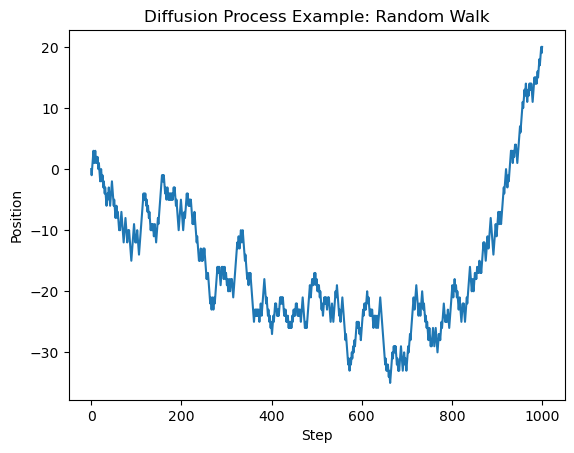

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 初始化参数
initial_position = 0  # 初始位置
steps = 1000  # 总步数
step_size = 1  # 每步移动的距离

# 初始化位置数组
positions = np.zeros(steps+1)
positions[0] = initial_position

# 执行向前扩散过程
for i in range(1, steps+1):
    # 随机选择方向并移动
    step_direction = np.random.choice([-1, 1])  # 随机选择前进或后退
    positions[i] = positions[i-1] + step_direction * step_size

# 绘制路径图
plt.plot(positions)
plt.xlabel('Step')
plt.ylabel('Position')
plt.title('Diffusion Process Example: Random Walk')

### $\beta_t$ scheduler

$\beta_t$ refers to something called schedule and values can range from 0 to 1.

- $\beta_1=0.0001$, $\beta_T=0.02$
- $q(x_t|x_{t-1})\sim \mathcal N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\mathbb 1)$
- $\alpha_t=1-\beta_t$
- $\bar\alpha_t=\Pi_{i=1}^t\alpha_i$

Text(0.5, 1.0, 'var')

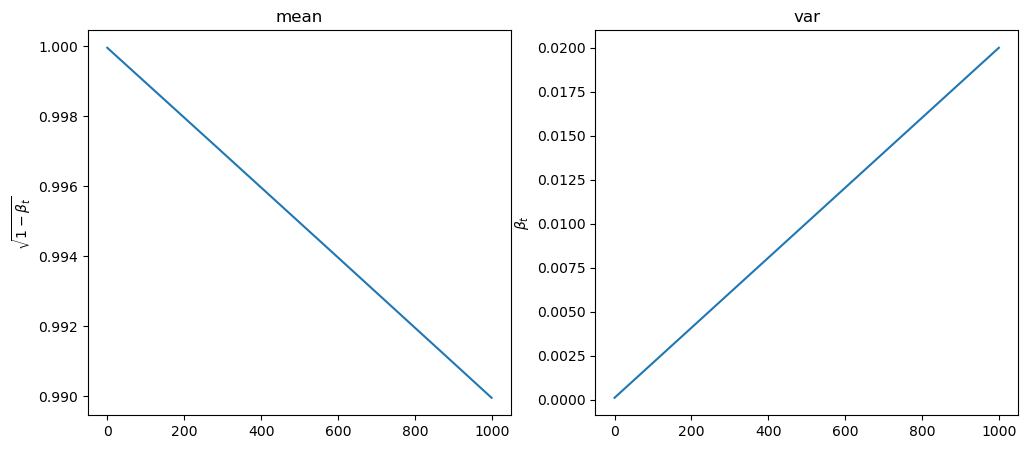

In [24]:
beta_1 = 0.0001
beta_T = 0.02
T = 1000
ts = np.linspace(0, T, T, endpoint=False)

plt.figure(figsize=(12, 5))
beta_ts = np.linspace(beta_1, beta_T, T)
plt.subplot(1, 2, 1)
plt.plot(np.sqrt(1- beta_ts))
plt.ylabel(r'$\sqrt{1-\beta_t}$')
plt.title('mean')

plt.subplot(1, 2, 2)
plt.plot(beta_ts)
plt.ylabel(r'$\beta_t$')
plt.title('var')

In [10]:
beta_1 = 0.0001
beta_T = 0.02
T = 1000
ts = np.linspace(0, T, T, endpoint=False)

beta_ts = np.linspace(beta_1, beta_T, T)
beta_cos = beta_T + (beta_1 - beta_T) * (np.cos(np.pi * ts / T) + 1) / 2

alpha_ln = 1 - beta_ts
alpha_ln_cumprob = np.cumprod(alpha_ln)

alpha_cos = 1 - beta_cos
alpha_cos_cumprob = np.cumprod(alpha_cos)

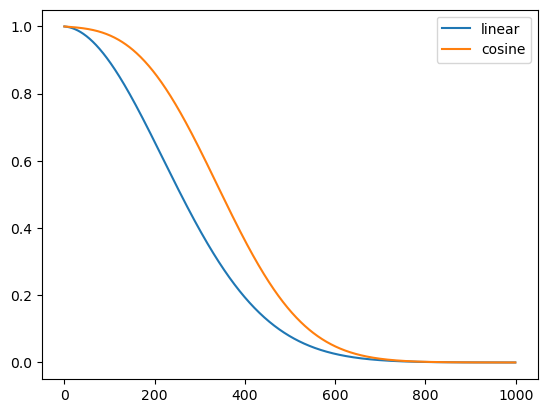

In [13]:
plt.plot(alpha_ln_cumprob)
plt.plot(alpha_cos_cumprob)
plt.legend(['linear', 'cosine'])

In [2]:
from diffusers import DDPMScheduler

In [3]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [11]:
noise_scheduler.config.beta_schedule, noise_scheduler.config.beta_start, noise_scheduler.config.beta_end

('linear', 0.0001, 0.02)

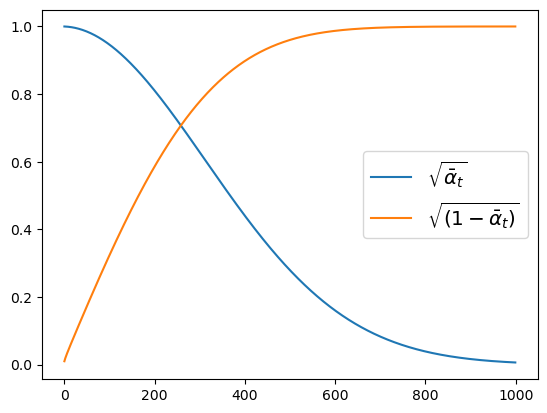

In [5]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

### ELBO in DDPM


https://www.youtube.com/watch?v=H45lF4sUgiE

- Encoder: $q(z|x)$, $x_0\rightarrow z_T$
- Decoder: $p(x|z)$, $z_T\rightarrow x_0$

对于 VAE

$$
\begin{split}
\log p(x)&=\log \int p(x,z)dz\\
&=\log\int p(x,z)\frac{q(z|x)}{q(z|x)}dz\\
&=\log E_{q(z|x)}\left[\frac{p(x,z)}{q(z|x)}\right]\\
&\geq E_{q(z|x)}\left[\log \frac{p(x,z)}{q(z|x)}\right]=E_{q(z|x)}[\log p(x|z)]-D_{KL}(q(z|x)||p(z))
\end{split}
$$

对于 diffusion

$$
\begin{split}
\log p(x_0)&=\log \int p(x_0,x_1,\cdots,x_T)dx_{1:T}=\log \int p(x_{0:T})dx_{1:T}\\
&=\log \int p(x_{0:T})\frac{q(x_{1:T}|x_0)}{q(x_{1:T}|x_0)}dx_{1:T}\\
&=\log E_{q({x_{1:T}|x_0})}\left[\frac{p(x_{0:T})}{q({x_{1:T}|x_0})}\right]\\
&\geq E_{q({x_{1:T}|x_0})}\left[\log\frac{p(x_{0:T})}{q({x_{1:T}|x_0})}\right]
\end{split}
$$

likelihood for diffusion process
- $q(x_t|x_{t-1})$: forward noising process 
- $p(x_{t-1}|x_t)$: reverse denoising process

$$
\begin{split}
&=\log\frac{p(x_{0:T})}{q(x_{1:T}|x_0)}\\
&=\log\frac{p(x_T)\Pi_{t=1}^Tp_\theta(x_{t-1}|x_t)}{q(x_1|x_0)\Pi_{t=2}^Tq(x_t|x_{t-1},x_0)}
\end{split}
$$

- 关于分母部分，应用贝叶斯公式

$$
\begin{split}
q(x_1|x_0)\Pi_{t=2}^Tq(x_t|x_{t-1},x_0)&=q(x_1|x_0)\Pi_{t=2}^T\frac{q(x_{t-1}|x_t,x_0)q(x_t|x_0)}{q(x_{t-1}|x_0)}\\
&=q(x_1|x_0)\frac{q(x_{T-1}|x_{T},x_0)q(x_T|x_0)q(x_{T-2}|x_{T-1},x_0)q(x_{T-1}|x_0)\cdots q(x_1|x_2,x_0)q(x_2|x_0)}{q(x_{T-1}|x_0)q(x_{T-2}|x_0)\cdots q(x_2|x_0)q(x_{1}|x_0)}\\
&=q(x_T|x_0)\Pi_{t=2}^Tq(x_{t-1}|x_t,x_0)
\end{split}
$$

- 因此上式可以进一步化简：

$$
\begin{split}
&=\log\frac{p(x_{0:T})}{q(x_{1:T}|x_0)}\\
&=\log\frac{p(x_T)\Pi_{t=1}^Tp_\theta(x_{t-1}|x_t)}{q(x_1|x_0)\Pi_{t=2}^Tq(x_t|x_{t-1},x_0)}\\
&=\log \frac{p(x_T)\Pi_{t=1}^Tp_\theta(x_{t-1}|x_t)}{q(x_T|x_0)\Pi_{t=2}^Tq(x_{t-1}|x_t,x_0)}\\
&=\log \frac{p(x_T)p(x_0|x_1)\Pi_{t=2}^Tp_\theta(x_{t-1}|x_t)}{q(x_T|x_0)\Pi_{t=2}^Tq(x_{t-1}|x_t,x_0)}\\
&=\log \frac{p(x_T)}{q(x_T|x_0)}+\log p(x_0|x_1)+\sum_{t=2}^T\log\frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t,x_0)}
\end{split}
$$

### $q(x_{t-1}|x_t,x_0)$

- given $x_0$ 初始未加噪原始图像


$$
\begin{split}
q(x_{t-1}|x_t,x_0)&=\frac{q(x_t|q_{t-1},x_0)q(x_{t-1}|x_0)}{q(x_t|x_0)}\\
&=\frac{\mathcal N(x_t;\sqrt{\alpha_t},(1-\alpha_t)I)\mathcal N(x_{t-1};\sqrt{\bar\alpha_{t-1}},(1-\bar\alpha_{t-1})I)}{\mathcal N(x_t;\sqrt{\bar \alpha_t}x_0,(1-\bar\alpha_t)I)}
\end{split}
$$

## Training & Sampling

In [23]:
Image(url='https://imgur.com/S7KH5hZ.png', width=600)

$$
\begin{split}
L_{\text{simple}}(\theta)&:=\mathbb E_{t,x_0,\epsilon}\left[\|\epsilon-\epsilon_\theta(\sqrt{\bar \alpha_t}x_0+\sqrt{1-{\bar \alpha_t}}\epsilon,t)\|^2\right]\\
x_t&=\sqrt{\bar \alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon
\end{split}
$$

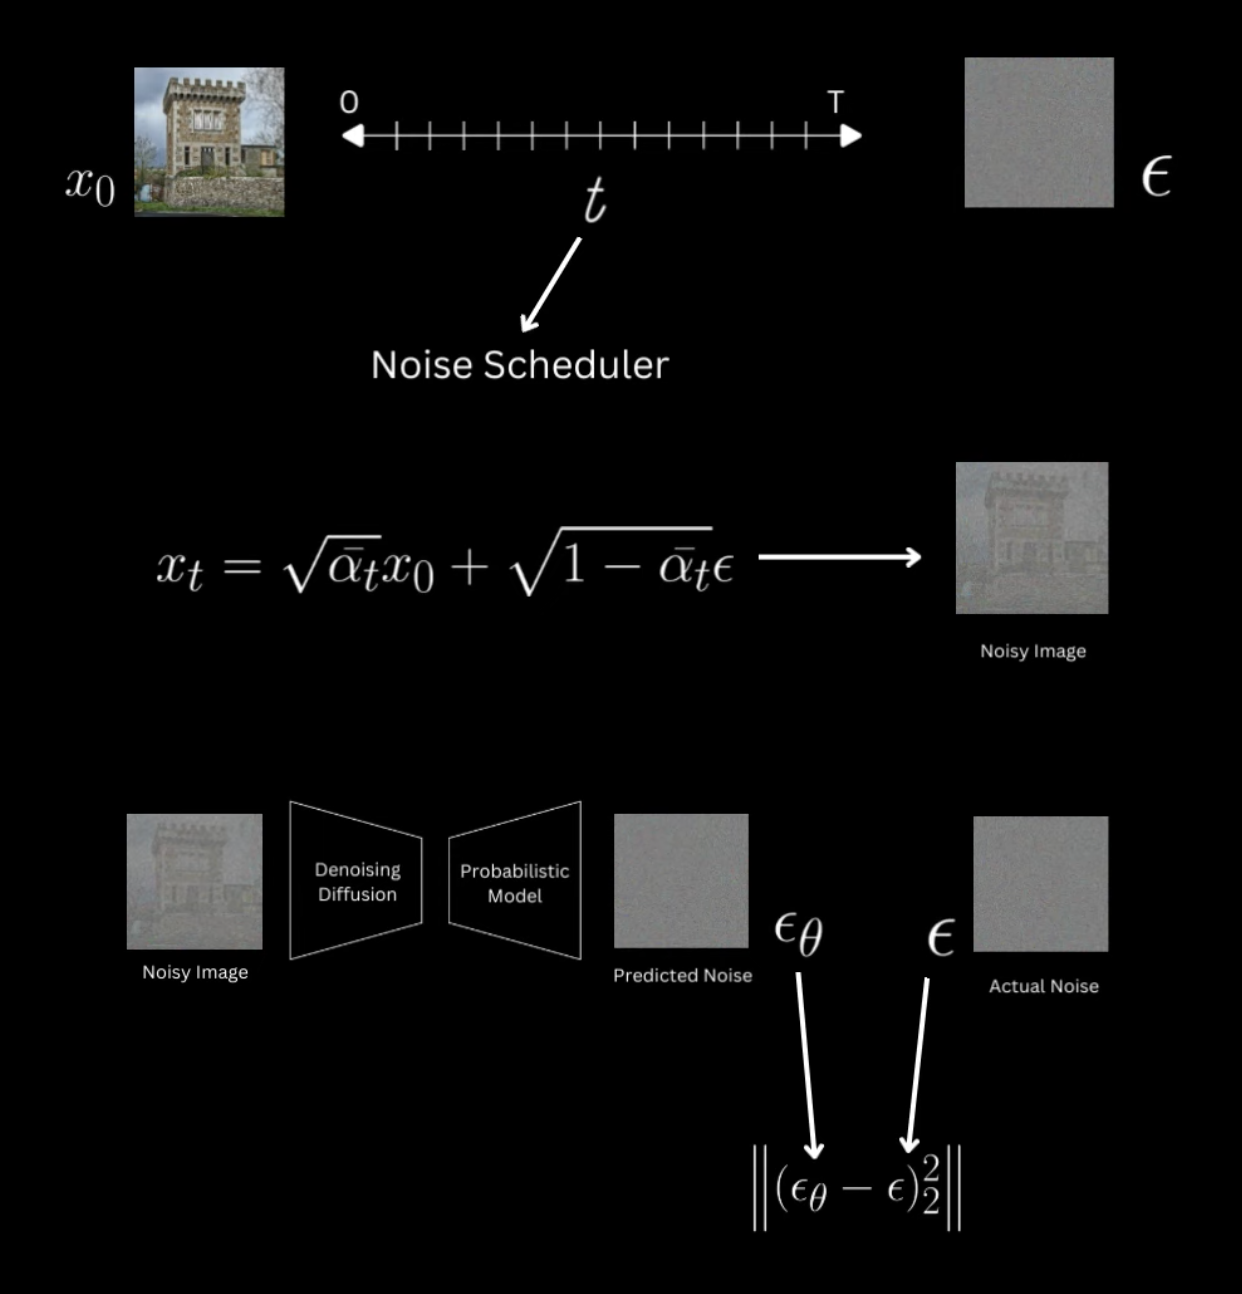

In [25]:
Image('../imgs/ddpm.png', width=400)